# -----------------------------------------------------------------------------------------
# 1. Setup
# -----------------------------------------------------------------------------------------

#### Import Packages

In [1]:
# For reading in Json file
import json

# general packages
import pandas as pd
import numpy as np
import time

#### Import Functions

In [2]:
# Load the autoreload extension
%load_ext autoreload
%autoreload 1

# Import functions for scraping the data
%aimport get_data
import get_data as gd

# Import functions for analysing the data
%aimport analyse_portfolio
import analyse_portfolio as ap

#### Configure Notebook

In [63]:
# Update the default number of rows that are displayed
pd.set_option('display.max_rows', 500)

# disable chained assignments
pd.options.mode.chained_assignment = None

# -----------------------------------------------------------------------------------------
# 2. Read in Transactions Data
# -----------------------------------------------------------------------------------------

#### Scrape Data to Populate Files

In [4]:
gd.create_company_ticker_to_name_map()
gd.create_exchange_ticker_to_name_map()

#### Read in Manually Populated Transactions Table

In [211]:
raw_transactions = gd.read_in_raw_transactions_data()

#### Use Scraped Data to Add Columns to Transactions Data

In [212]:
# Add company name
transactions_comp_name = gd.create_company_name_col_using_ticker(raw_transactions)

The following stocks did not have an associated company name:
|    | stock_ticker   | exchange_ticker   |
|---:|:---------------|:------------------|
|  6 | LGD            | TOR               |
| 10 | SVE            | TSV               |


In [213]:
# Add Exchange name
transactions_exch_name = gd.create_exchange_name_nd_curency_cols_using_ticker(transactions_comp_name)

In [214]:
# Add aggregate price columns that track fees, stock prices, bep over time, among others
transactions = gd.add_aggregate_price_columns(transactions_exch_name)

# -----------------------------------------------------------------------------------------
# 3. Create Stock Valuation Table
# -----------------------------------------------------------------------------------------

#### Scrape Historic Stock Prices & Dividends Recieved For Each Stock

In [215]:
unique_tickers_list = list(transactions["stock_ticker"].drop_duplicates())
ticker_start_date_list = [str(min(transactions[transactions["stock_ticker"] == ticker]["date"]))[:10] for ticker in unique_tickers_list]
gd.create_table_of_historic_stock_prices(unique_tickers_list, ticker_start_date_list)

- LGD: No data found for this date range, symbol may be delisted
LGD not found
- SVE: No data found for this date range, symbol may be delisted
SVE not found


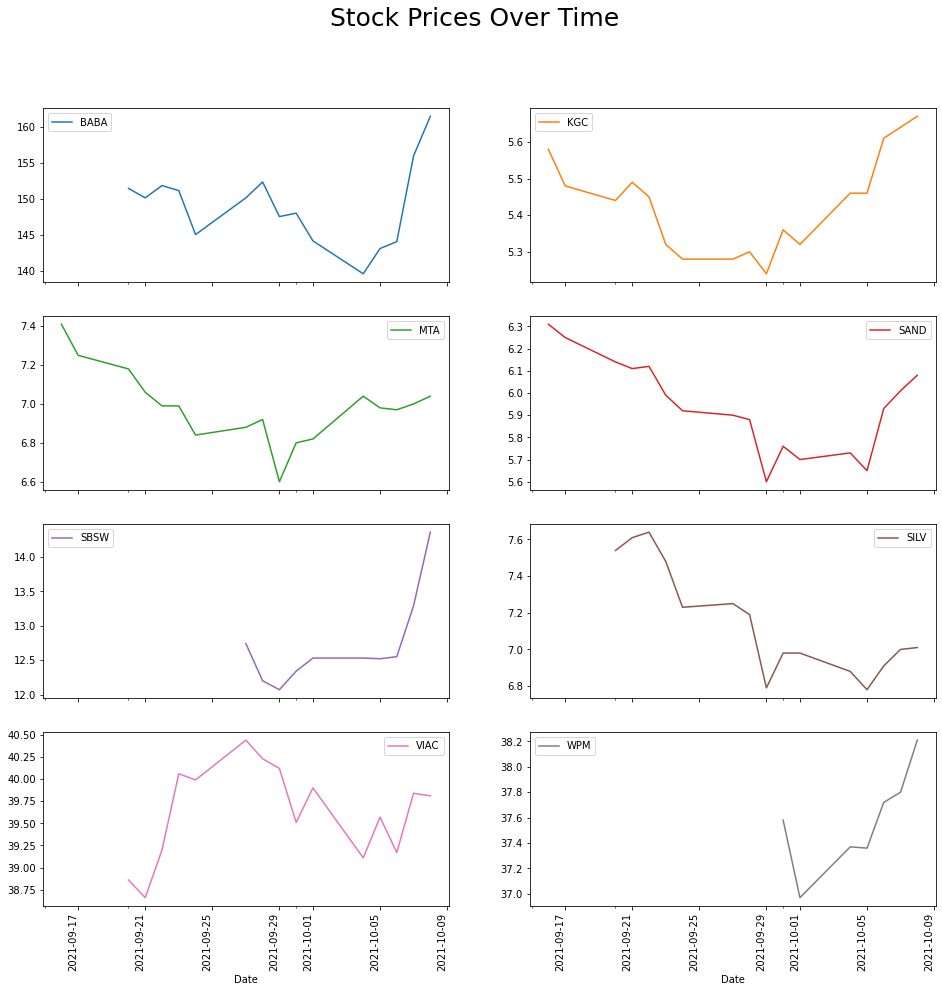

In [216]:
ap.plot_stock_prices()

#### Scrape Historic Exchange Rates

In [217]:
base_currency = 'EUR'

In [218]:
unique_currency_list = list(transactions["currency"].drop_duplicates())
start_date = min(transactions["date"]).date()
gd.create_exchange_rate_to_date_map(base_currency, unique_currency_list, start_date)

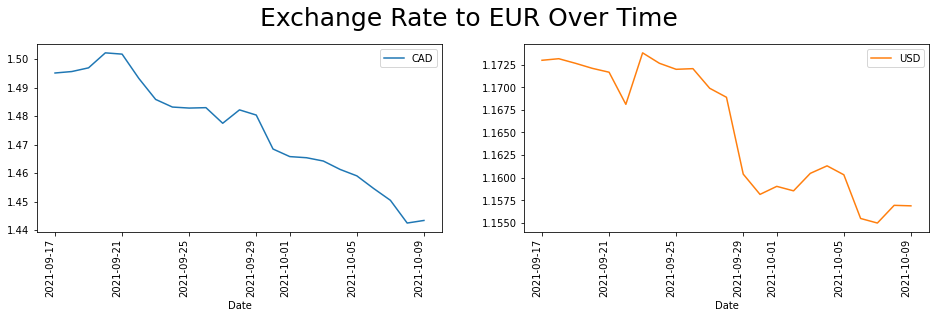

In [219]:
ap.plot_exchange_rates(base_currency)

#### Calculate Daily Account Cash Balance

In [220]:
# get the cumulative amount paid into the account broken down by day
daily_amount_in_account_to_date_df = gd.calculate_amount_in_cumulative_account_each_day()

In [221]:
# get the cumulative amount spend on stocks broken down by day
daily_amount_spent_to_date_df = gd.calculate_cumulative_amount_spent_each_day(transactions)

In [222]:
# get the daily cash balance
daily_cash_balance = daily_amount_in_account_to_date_df.sub(daily_amount_spent_to_date_df, fill_value=0)

In [223]:
# Merge these into one table
daily_balance_summary_table = pd.concat([daily_amount_in_account_to_date_df, daily_amount_spent_to_date_df, daily_cash_balance], axis=1).set_axis(["in_account", "spent", "balance"], axis=1)

#### Calculate Valuation Table For Each Stock

In [224]:
# Define the base currency
base_currency = "EUR"

# Define the valuation period
val_period = "daily"

# create the valuation tables for each stock
map_stock_to_valuation_table = ap.create_all_valuation_tables(transactions, base_currency, val_period)

Error retrieving stock price for ticker: 'LGD' (TOR). No valuation table calculated for this stock!


Error retrieving stock price for ticker: 'SVE' (TSV). No valuation table calculated for this stock!


#### Visualise Stock Performance Over Time

In [ ]:
ap.visualise_profit_over_time(map_stock_to_valuation_table)

#### Visualise Portfolio on Specific Date

In [ ]:
selected_date = "2021-10-10"

portfolio_df_on_date = ap.get_portflio_on_date(map_stock_to_valuation_table, selected_date)

In [ ]:
ap.visualise_portfolio_pie_chart(portfolio_df_on_date, base_currency)